In [1]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import pandas as pd
import neptune 
import datetime

tf.enable_eager_execution()
tf.__version__, tf.executing_eagerly()

W1026 11:58:11.811715 4638029248 __init__.py:848] 
Bad key text.latex.unicode in file /Users/brennangebotys/miniconda2/envs/meta/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.0/matplotlibrc.template
or from the matplotlib source distribution
W1026 11:58:11.814242 4638029248 __init__.py:848] 
Bad key savefig.frameon in file /Users/brennangebotys/miniconda2/envs/meta/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.0/matplotlibrc.template
or from the matplotlib source distribution
W1026 11:58:11.815218 4638029248 __init__.py:848] 
Bad key nbagg.transparent in file /Users/brenna

('1.15.0', True)

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
def _update_keys(d, prefix):
    keys = list(d.keys())
    for k in keys: 
        d['{}_{}'.format(prefix, k)] = d.pop(k)

class NeptuneWriter:
    def __init__(self, proj_name):
        self.project = neptune.init(proj_name)
        self.train()
        self.has_started = False

    def start(self, args, **kwargs):
        self.experiment = self.project.create_experiment(
            name=args['experiment_name'], params=args, **kwargs)
        self.has_started = True 

    def fin(self):
        if self.has_started:
            # will finish when all data has been sent
            self.experiment.stop()
            self.has_started = False

    def write(self, data, step):
        if self.has_started:
            if not self.train_state:
                _update_keys(data, 'test')
            for k in data.keys():
                self.experiment.log_metric(k, step, data[k])
        else: 
            print('Warning: Writing to dead writer - call .start() first')

    def id(self):
        return self.experiment.id

    def eval(self): self.train_state = False 
    def train(self): self.train_state = True 


In [13]:
# dataloading by https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch
batch_size = 32 

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)
x_train = np.reshape(x_train, (-1, 784)).astype(np.float32)
x_test = np.reshape(x_test, (-1, 784)).astype(np.float32)
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

# Reserve 10,000 samples for validation.
x_val = x_train[-10000:]
y_val = y_train[-10000:]
y_train = y_train[:-10000]
x_train = x_train[:-10000]

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

(60000, 28, 28)


In [12]:
def evaluate_on_test(model):
    # score on test-set 
    acc_metric = tf.keras.metrics.CategoricalAccuracy()

    y_preds = model.predict(x_test)
    test_loss = loss_func(y_test, y_preds).numpy()

    acc_metric.reset_states()
    acc_metric.update_state(y_test, y_preds)
    test_acc = acc_metric.result().numpy()

    return test_loss, test_acc

def evalute_on_val(model):
    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    losses = []
    for xb, yb in val_dataset:
        y_preds = model(xb, training=False)
        loss = loss_func(yb, y_preds).numpy()
        # Update val metrics
        acc_metric.update_state(yb, y_preds)
        losses.append(loss)
    val_acc = acc_metric.result()
    return np.mean(losses), val_acc

In [6]:
def get_model(dropout=0.):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(784,)))
    if dropout > 0.:
        model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(10))
    return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [7]:
optimizer = tf.keras.optimizers.SGD(1e-2)
loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [8]:
writer = NeptuneWriter('gebob19/672')

# Baseline

In [10]:
from tqdm.notebook import tqdm 
epochs = 1
step = 0

model = get_model()

writer.start({
    'experiment_name': 'baseline',
    'epochs': epochs, 
    'batchsize': batch_size,
})

for e in range(epochs):
    losses = []
    for xb, yb in tqdm(train_dataset): 
        with tf.GradientTape() as g: 
            y_preds = model(xb, training=True)
            loss = loss_func(yb, y_preds)

        grads = g.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        losses.append(loss)
        step += 1
        metrics = {}
        
        if step % 100 == 0:
            metrics['train_loss'] = np.mean(losses)
            losses = []

        if step % 200 == 0: 
            val_loss, val_acc = evalute_on_val(model)
            metrics['val_acc'] = val_acc
            metrics['val_loss'] = val_loss

        if metrics:     
            writer.write(metrics, step)

test_loss, test_acc = evaluate_on_test(model)
writer.write({'test_acc': test_acc, 'test_loss': test_loss}, 0)

writer.fin()

W1026 11:59:18.601130 4638029248 gpu_monitor.py:65] NVMLError: NVML Shared Library Not Found - GPU usage metrics may not be reported.
https://ui.neptune.ai/gebob19/672/e/672-5


# Lipschitz 

In [142]:
reg_constant = 0.01
model = get_model()

epochs = 1
for e in range(epochs):
    for xb, yb in tqdm(train_dataset): 
        # lipschitz regularization
        reg_constant = 0.01 
        with tf.GradientTape() as gg:
            with tf.GradientTape() as g: 
                y_pred = model(xb)
                loss = loss_fn(yb, y_pred)
            grads = g.gradient(loss, model.trainable_weights)
            # compute lipschitz term gradients 
            gg_grads = gg.gradient([reg_constant * (tf.norm(v, 2) - 1) ** 2 for v in grads], model.trainable_weights)

        # optimize off of loss + lipschitz gradients 
        final_grads = [g + gg for g, gg in zip(grads, gg_grads)]
        optimizer.apply_gradients(zip(final_grads, model.trainable_weights))

# Dropout

In [158]:
dropout_constant = 0.1
model = get_model(dropout=dropout_constant)

epochs = 1
for e in range(epochs):
    for xb, yb in tqdm(train_dataset): 
        with tf.GradientTape() as g: 
            y_preds = model(xb, training=True)
            loss = loss_func(yb, y_preds)

        grads = g.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

# Spectral Norm 

In [166]:
reg_constant = 0.01
model = get_model()
v = tf.random.normal((10, 1), mean=0., stddev=1.)

epochs = 1
for e in range(epochs):
    for xb, yb in tqdm(train_dataset): 
        with tf.GradientTape() as g: 
            y_preds = model(xb, training=True)
            loss = loss_func(yb, y_preds)
        grads = g.gradient(loss, model.trainable_weights)
        
        # apply spectral norm reg. 
        W = model.trainable_weights[0]
        W_grad = grads[0]
        u = W @ v 
        v = tf.transpose(W) @ u 
        sigma = tf.norm(u, 2) / tf.norm(v, 2)
        reg_value = sigma * (u @ tf.transpose(v))
        W_grad += reg_constant * reg_value
        grads[0] = W_grad 

        optimizer.apply_gradients(zip(grads, model.trainable_weights))


# Orthogonal Norm 

In [64]:
reg_constant = 0.01

def orthogonal_reg(W):
    orthog_term = tf.abs(W @ tf.transpose(W) - tf.eye(W.shape.as_list()[0])).sum()
    return reg_constant * orthog_term

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(784,)))
model.add(tf.keras.layers.Dense(10, kernel_regularizer=orthogonal_reg))

epochs = 1
for e in range(epochs):
    for xb, yb in tqdm(train_dataset): 
        with tf.GradientTape() as g: 
            y_preds = model(xb, training=True)
            loss = loss_func(yb, y_preds)

        grads = g.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

In [5]:
class Norm(tf.keras.layers.Layer):
    def __init__(self, mean, std): 
        super().__init__()
        self.mean = mean 
        self.std = std

    def call(self, x):
        return (x - self.mean) / self.std 

[32, 1]

In [44]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,)))
model.add(Norm(train_x.mean(), train_x.std()))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation=None))

loss_function = tf.keras.losses.mae
optimizer = tf.keras.optimizers.SGD(1e-2)
epochs = 200 

for e in range(epochs):

    for x, y in dset.batch(32):
        with tf.GradientTape() as tape: 
            y_preds = model(x, training=True)
            loss = loss_function(y, y_preds)

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    print('loss {}: {}'.format(e, loss.numpy().mean()))

loss 0: 8771.8984375
loss 1: 1030.867919921875
loss 2: 5777.12255859375
loss 3: 977.53369140625
loss 4: 5467.7705078125
loss 5: 5717.18896484375
loss 6: 4984.2568359375
loss 7: 6343.7958984375
loss 8: 4958.06640625
loss 9: 5616.2578125
loss 10: 6328.39501953125
loss 11: 5682.556640625
loss 12: 5673.6142578125
loss 13: 5661.7314453125
loss 14: 6349.03857421875
loss 15: 5707.57421875
loss 16: 5684.8330078125
loss 17: 5661.82470703125
loss 18: 6337.99951171875
loss 19: 5702.5419921875
loss 20: 5666.26318359375
loss 21: 6360.0244140625
loss 22: 5699.14111328125
loss 23: 5692.6181640625
loss 24: 5609.3173828125
loss 25: 6325.6435546875
loss 26: 5663.75390625
loss 27: 5664.0341796875
loss 28: 6361.44140625
loss 29: 6027.16015625
loss 30: 5635.826171875
loss 31: 5626.685546875
loss 32: 5624.384765625
loss 33: 6326.7548828125
loss 34: 5667.0302734375
loss 35: 5664.734375
loss 36: 5983.19921875
loss 37: 6341.3857421875
loss 38: 5729.296875
loss 39: 5680.4453125
loss 40: 5992.66015625
loss 41: 6

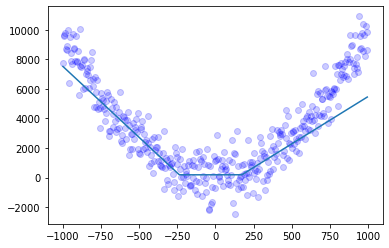

In [45]:
# model visualize
plt.scatter(train_x[:, 0], train_y[:, 0], color='blue', alpha=0.2, label='observered')
pred_y = model(train_x).numpy()
plt.plot(train_x[:, 0], pred_y[:, 0])

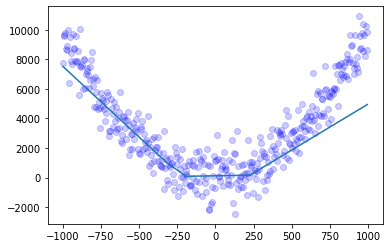

In [43]:
# model visualize
plt.scatter(train_x[:, 0], train_y[:, 0], color='blue', alpha=0.2, label='observered')
pred_y = model(train_x).numpy()
plt.plot(train_x[:, 0], pred_y[:, 0])

## L1 + L2 Weight Reg 

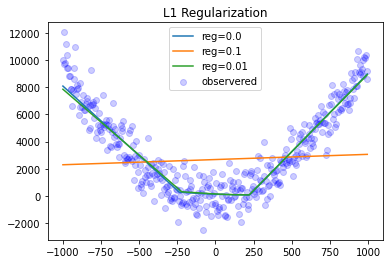

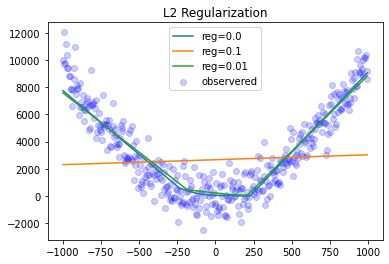

In [79]:
def l1_reg(weights):
   return reg_constant * tf.math.reduce_sum(tf.math.abs(weights))

def l2_reg(weights):
   return reg_constant * tf.math.reduce_sum(tf.math.abs(weights))

def get_model(reg_func, weights=None):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(1,)))
    model.add(Norm(train_x.mean(), train_x.std()))
    model.add(tf.keras.layers.Dense(32, kernel_regularizer=reg_func, activation='relu'))
    model.add(tf.keras.layers.Dense(1,  kernel_regularizer=reg_func, activation=None))

    if weights: model.set_weights(weights)
    return model  
   
def run_experiment(model, reg_constants, epochs=200):
    loss_function = tf.keras.losses.mae
    optimizer = tf.keras.optimizers.SGD(1e-2)
    init_weights = model.get_weights()

    plt.scatter(train_x[:, 0], train_y[:, 0], color='blue', alpha=0.2, label='observered')
    global reg_constant
    for r in reg_constants:
        reg_constant = r

        # model training
        model.set_weights(init_weights)
        model.compile(optimizer=optimizer, loss=loss_function)
        model.fit(train_x, train_y, epochs=epochs, verbose=0)

        # model visualize
        pred_y = model(train_x).numpy()
        plt.plot(train_x[:, 0], pred_y[:, 0], label='reg={}'.format(r))

    plt.legend()

model = get_model(l1_reg)
run_experiment(model, [0., 0.1, 0.01])
plt.title('L1 Regularization')
plt.show()

model = get_model(l2_reg)
run_experiment(model, [0., 0.1, 0.01])
plt.title('L2 Regularization')
plt.show()